**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [3]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.initialize_all_variables()

In [4]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[ 0.99715191 -0.96573043  0.48263517  0.75103307  0.63005513]
 [ 0.72274023 -0.99146956 -0.2785553   0.99997073 -0.09475061]
 [-0.89563441 -0.99789727 -0.80001158  1.         -0.7313292 ]
 [-1.          1.          0.499874    0.99996275 -1.        ]]


In [6]:
print(Y1_val)

[[-0.99999994 -0.30562368 -0.99982792  1.         -0.99349439]
 [ 0.97062987 -0.23609701 -0.92210275  0.48410925 -0.56634736]
 [-1.          0.93040472 -0.87783211  0.99999487 -0.99165547]
 [-0.99999988  0.99961126  0.94231671 -0.27352917 -0.9958083 ]]


## Using `rnn()`

In [7]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.initialize_all_variables()

In [8]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [9]:
Y0_val

array([[-0.6512959 ,  0.89083946, -0.85044301,  0.323282  , -0.8783927 ],
       [-0.45838216,  0.99845564, -0.99198878, -0.54369295, -0.99836361],
       [-0.20981368,  0.99997938, -0.99959975, -0.91445529, -0.99997944],
       [ 0.99947661, -0.91491669,  0.80572295, -0.99604207,  0.81913596]], dtype=float32)

In [10]:
Y1_val

array([[ 0.76672292,  0.99991781, -0.9992581 , -0.99868894, -0.99994487],
       [-0.79488361,  0.53733993, -0.80716753, -0.56864417,  0.08659729],
       [ 0.13486399,  0.99889988, -0.99441969, -0.99375516, -0.9938038 ],
       [ 0.88772398,  0.83640993,  0.25747493, -0.68455571, -0.60166305]], dtype=float32)

In [11]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(tf.get_default_graph())

## Packing sequences

In [13]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unpack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.pack(output_seqs), perm=[1, 0, 2])

init = tf.initialize_all_variables()

In [14]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [15]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.97331583  1.          1.          0.97554523 -0.98747736]
 [-0.82908219 -0.52926612  0.32085186 -0.54714954  0.79990309]
 [-0.98323536  0.99997234  0.99994755  0.56912678 -0.41493124]
 [-0.4494451   0.91924781  0.99745786  0.24391253  0.39466459]]


## Using `dynamic_rnn()`

In [16]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.initialize_all_variables()

In [17]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    print("outputs =", outputs.eval(feed_dict={X: X_batch}))

outputs = [[[-0.23382208  0.76683432  0.93643713 -0.80472916 -0.60019767]
  [-0.99351406  0.99999964  0.99759728 -0.98060888  0.76075202]]

 [[-0.88139206  0.99887061  0.99753082 -0.981947   -0.64462322]
  [ 0.29748455  0.72552329  0.09691043  0.03584142  0.32892999]]

 [[-0.98728108  0.99999523  0.99990696 -0.99846756 -0.68508393]
  [-0.94087839  0.99995995  0.92983443 -0.8774581   0.71102041]]

 [[-0.99994767  0.99989921 -0.99988997  0.99813324  0.99946588]
  [-0.96028382  0.98852354 -0.18959917 -0.63675886 -0.86672658]]]


In [18]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [19]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

init = tf.initialize_all_variables()

In [20]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [21]:
print(outputs_val)

[[[ 0.942316    0.12856117 -0.34410363 -0.86847639  0.5787816 ]
  [ 1.          0.99979937 -0.99980366 -0.87422884  0.99999756]]

 [[ 0.99999815  0.90053409 -0.96986437 -0.96849412  0.99667072]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 1.          0.99293071 -0.9990412  -0.9927482   0.99997932]
  [ 1.          0.99874562 -0.99058747 -0.28668702  0.99907541]]

 [[ 0.99998087  0.99997705 -0.98866355  0.99963832  0.98265362]
  [ 0.96435863  0.97204041 -0.46794799  0.8993032   0.81080031]]]


In [22]:
print(states_val)

[[ 1.          0.99979937 -0.99980366 -0.87422884  0.99999756]
 [ 0.99999815  0.90053409 -0.96986437 -0.96849412  0.99667072]
 [ 1.          0.99874562 -0.99058747 -0.28668702  0.99907541]
 [ 0.96435863  0.97204041 -0.46794799  0.8993032   0.81080031]]


## Training a sequence classifier

In [23]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.variable_scope("", initializer=tf.contrib.layers.variance_scaling_initializer()):
    basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.initialize_all_variables()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [25]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.7 Test accuracy: 0.7218
1 Train accuracy: 0.72 Test accuracy: 0.776
2 Train accuracy: 0.866667 Test accuracy: 0.8695
3 Train accuracy: 0.926667 Test accuracy: 0.8955
4 Train accuracy: 0.94 Test accuracy: 0.9205
5 Train accuracy: 0.926667 Test accuracy: 0.92
6 Train accuracy: 0.966667 Test accuracy: 0.937
7 Train accuracy: 0.94 Test accuracy: 0.9383
8 Train accuracy: 0.913333 Test accuracy: 0.9453
9 Train accuracy: 0.953333 Test accuracy: 0.9363
10 Train accuracy: 0.98 Test accuracy: 0.9513
11 Train accuracy: 0.92 Test accuracy: 0.9499
12 Train accuracy: 0.98 Test accuracy: 0.9499
13 Train accuracy: 0.986667 Test accuracy: 0.9522
14 Train accuracy: 0.98 Test accuracy: 0.9509
15 Train accuracy: 0.953333 Test accuracy: 0.9579
16 Train accuracy: 0.98 Test accuracy: 0.9515
17 Train accuracy: 0.973333 Test accuracy: 0.9579
18 Train accuracy: 0.973333 Test accuracy: 0.9634
19 Train accuracy: 0.953333 Test accuracy: 0.9561
20 Train accuracy: 0.973333 Test accuracy: 0.9605
2

# Multi-layer RNN

In [26]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons1 = 150
n_neurons2 = 100
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

hidden1 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons1, activation=tf.nn.relu)
hidden2 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons2, activation=tf.nn.relu)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell([hidden1, hidden2])
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.initialize_all_variables()

In [27]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.693333 Test accuracy: 0.6555
1 Train accuracy: 0.84 Test accuracy: 0.8482
2 Train accuracy: 0.853333 Test accuracy: 0.8747
3 Train accuracy: 0.96 Test accuracy: 0.9187
4 Train accuracy: 0.96 Test accuracy: 0.9432
5 Train accuracy: 0.933333 Test accuracy: 0.9385
6 Train accuracy: 0.926667 Test accuracy: 0.9435
7 Train accuracy: 0.96 Test accuracy: 0.9517
8 Train accuracy: 0.966667 Test accuracy: 0.9461
9 Train accuracy: 0.953333 Test accuracy: 0.9553
10 Train accuracy: 0.98 Test accuracy: 0.9625
11 Train accuracy: 0.946667 Test accuracy: 0.9605
12 Train accuracy: 0.96 Test accuracy: 0.9676
13 Train accuracy: 0.993333 Test accuracy: 0.9589
14 Train accuracy: 0.973333 Test accuracy: 0.9644
15 Train accuracy: 0.96 Test accuracy: 0.9632
16 Train accuracy: 0.966667 Test accuracy: 0.962
17 Train accuracy: 0.98 Test accuracy: 0.9649
18 Train accuracy: 0.966667 Test accuracy: 0.9648
19 Train accuracy: 0.986667 Test accuracy: 0.968
20 Train accuracy: 0.946667 Test accuracy: 0

# Time series

In [28]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


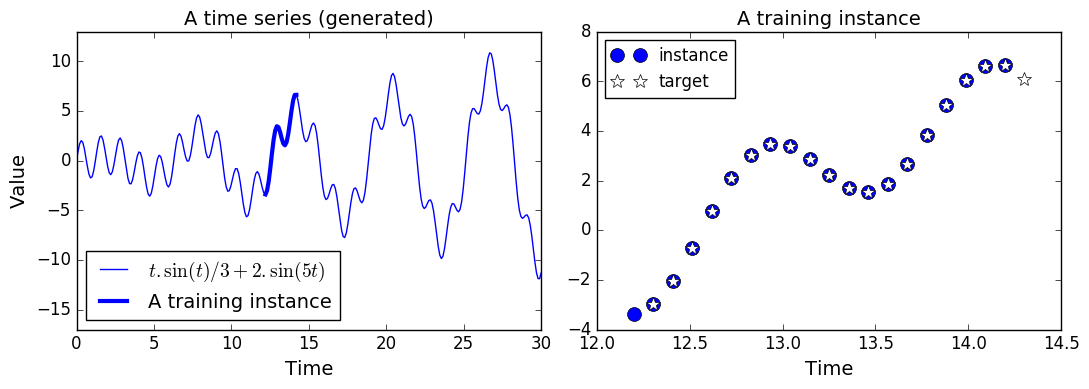

In [29]:
t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [30]:
X_batch, y_batch = next_batch(1, n_steps)

In [31]:
np.c_[X_batch[0], y_batch[0]]

array([[-2.92904642, -3.67374968],
       [-3.67374968, -3.918505  ],
       [-3.918505  , -3.72330675],
       [-3.72330675, -3.25210323],
       [-3.25210323, -2.73142518],
       [-2.73142518, -2.39372837],
       [-2.39372837, -2.41933451],
       [-2.41933451, -2.89119797],
       [-2.89119797, -3.77358492],
       [-3.77358492, -4.91989615],
       [-4.91989615, -6.10772886],
       [-6.10772886, -7.09260281],
       [-7.09260281, -7.6672054 ],
       [-7.6672054 , -7.71165809],
       [-7.71165809, -7.22250348],
       [-7.22250348, -6.31332144],
       [-6.31332144, -5.18682705],
       [-5.18682705, -4.08528436],
       [-4.08528436, -3.23137752],
       [-3.23137752, -2.77401558]])

## Using an `OuputProjectionWrapper`

In [32]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.initialize_all_variables()

In [33]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 18363.0
100 	MSE: 460.264
200 	MSE: 188.349
300 	MSE: 79.7485
400 	MSE: 55.1912
500 	MSE: 62.5532
600 	MSE: 48.6516
700 	MSE: 48.1635
800 	MSE: 43.9179
900 	MSE: 48.5993
[[[-3.47008657]
  [-2.51267362]
  [-1.18296444]
  [ 0.68082786]
  [ 2.2347033 ]
  [ 3.12824368]
  [ 3.52223229]
  [ 3.32184052]
  [ 2.83389449]
  [ 2.18490314]
  [ 1.69169581]
  [ 1.5186218 ]
  [ 1.9225558 ]
  [ 2.73621488]
  [ 3.85639024]
  [ 5.07873535]
  [ 6.10591364]
  [ 6.67857647]
  [ 6.67601919]
  [ 6.06514454]]]


Saving figure time_series_pred_plot


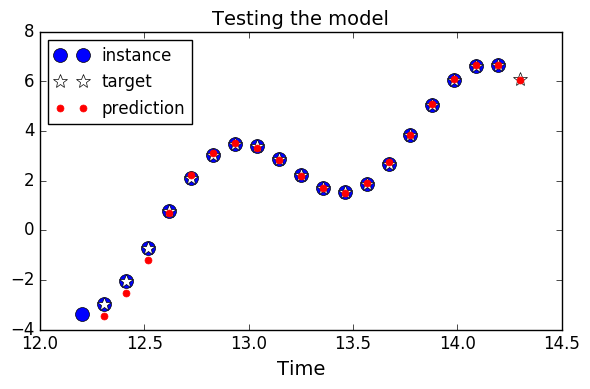

In [34]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [35]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.initialize_all_variables()

In [36]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 22003.0
100 	MSE: 627.62
200 	MSE: 277.0
300 	MSE: 147.352
400 	MSE: 76.7669
500 	MSE: 58.6978
600 	MSE: 51.0611
700 	MSE: 58.2317
800 	MSE: 43.9699
900 	MSE: 49.0574
[[[-3.50358176]
  [-2.55776238]
  [-1.18039787]
  [ 0.65069014]
  [ 2.09318376]
  [ 3.07957363]
  [ 3.51863217]
  [ 3.34387612]
  [ 2.83897853]
  [ 2.18822718]
  [ 1.71263635]
  [ 1.46465611]
  [ 1.85618472]
  [ 2.77506709]
  [ 3.92803097]
  [ 5.13883114]
  [ 6.15240669]
  [ 6.66308022]
  [ 6.65433741]
  [ 6.08840942]]]


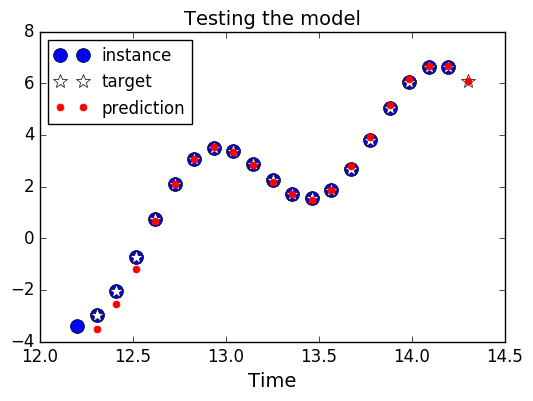

In [37]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

0 	MSE: 14983.2
100 	MSE: 469.065
200 	MSE: 201.205
300 	MSE: 67.0939
400 	MSE: 66.6101
500 	MSE: 59.1983
600 	MSE: 51.0404
700 	MSE: 52.3786
800 	MSE: 52.3609
900 	MSE: 47.2635
1000 	MSE: 50.3522
1100 	MSE: 50.9879
1200 	MSE: 52.5301
1300 	MSE: 39.9322
1400 	MSE: 46.3595
1500 	MSE: 32.6317
1600 	MSE: 47.2008
1700 	MSE: 36.8811
1800 	MSE: 43.6736
1900 	MSE: 40.6173


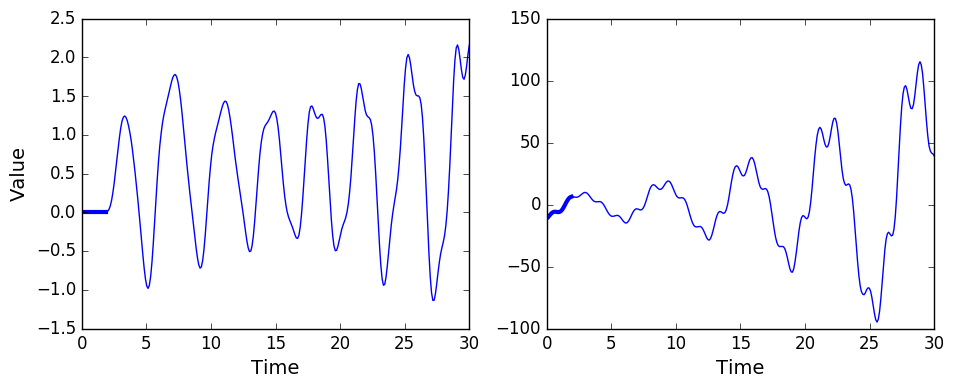

In [38]:
n_iterations = 2000
batch_size = 50
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
#save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [39]:
tf.reset_default_graph()

n_inputs = 2
n_neurons = 100
n_layers = 3
n_steps = 5
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell([basic_cell] * n_layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.initialize_all_variables()

In [40]:
X_batch = rnd.rand(2, n_steps, n_inputs)

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [42]:
outputs_val.shape

(2, 5, 100)

## Dropout

In [45]:
tf.reset_default_graph()
from tensorflow.contrib.layers import fully_connected

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

is_training = True

def deep_rnn_with_dropout(X, y, is_training):
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
    if is_training:
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
    multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell([cell] * n_layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    return outputs, loss, training_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)
init = tf.initialize_all_variables()
saver = tf.train.Saver()

In [46]:
n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

0 	MSE: 12755.6
100 	MSE: 4582.47
200 	MSE: 3705.44
300 	MSE: 4036.22
400 	MSE: 3668.54
500 	MSE: 3162.41
600 	MSE: 3784.85
700 	MSE: 2811.0
800 	MSE: 2883.08
900 	MSE: 2275.03
1000 	MSE: 3245.93
1100 	MSE: 3142.94
1200 	MSE: 2506.57
1300 	MSE: 2843.77
1400 	MSE: 2600.08
1500 	MSE: 2477.46
1600 	MSE: 2470.48
1700 	MSE: 3312.73
1800 	MSE: 2122.69
1900 	MSE: 2112.98


# LSTM

In [55]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, state_is_tuple=True)
multi_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell]*3, state_is_tuple=True)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = fully_connected(top_layer_h_state, n_outputs, activation_fn=None, scope="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.initialize_all_variables()

In [56]:
states

(LSTMStateTuple(c=<tf.Tensor 'RNN/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'RNN/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'RNN/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'RNN/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'RNN/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'RNN/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [57]:
top_layer_h_state

<tf.Tensor 'RNN/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [58]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.853333 Test accuracy = 0.8385
Epoch 1 Train accuracy = 0.953333 Test accuracy = 0.8952
Epoch 2 Train accuracy = 0.933333 Test accuracy = 0.9356
Epoch 3 Train accuracy = 0.92 Test accuracy = 0.9412
Epoch 4 Train accuracy = 0.986667 Test accuracy = 0.9539
Epoch 5 Train accuracy = 0.966667 Test accuracy = 0.9565
Epoch 6 Train accuracy = 0.98 Test accuracy = 0.9652
Epoch 7 Train accuracy = 0.98 Test accuracy = 0.9647
Epoch 8 Train accuracy = 0.98 Test accuracy = 0.9732
Epoch 9 Train accuracy = 0.973333 Test accuracy = 0.9729


# Distributing layers across devices

In [59]:
import tensorflow as tf

class DeviceCellWrapper(tf.nn.rnn_cell.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [60]:
tf.reset_default_graph()

n_inputs = 5
n_neurons = 100
devices = ["/cpu:0"]*5
n_steps = 20
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
lstm_cells = [DeviceCellWrapper(device, tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons))
              for device in devices]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
init = tf.initialize_all_variables()

In [61]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: rnd.rand(2, n_steps, n_inputs)}))

[[[ -3.62410322e-02   5.36520081e-03  -8.48066621e-03 ...,   9.47943889e-03
    -1.64868849e-04   4.30348143e-03]
  [ -5.65063618e-02   1.96487941e-02   3.04428358e-02 ...,  -1.61463320e-02
    -7.38892034e-02  -4.37535830e-02]
  [ -4.71536815e-02  -9.79799852e-02  -2.46124659e-02 ...,   8.38893279e-02
    -1.28212735e-01  -1.43267050e-01]
  ..., 
  [ -2.71415681e-01   2.47666255e-01  -2.45113403e-01 ...,   6.97874092e-03
    -3.33116591e-01  -1.10748738e-01]
  [ -1.94742754e-01   1.71515942e-01  -2.69154727e-01 ...,  -1.24836780e-01
    -3.50653201e-01  -2.37404406e-01]
  [ -1.91879243e-01   1.60464764e-01  -2.04435155e-01 ...,  -5.08808121e-02
    -2.38990977e-01  -9.71127152e-02]]

 [[ -7.06452206e-02  -2.17116368e-03  -2.48030275e-02 ...,   1.39924334e-02
     1.99646037e-02   8.69250204e-03]
  [ -1.12675831e-01   2.30047554e-02   3.91782485e-02 ...,  -3.73628139e-02
    -5.96980676e-02  -8.46209824e-02]
  [  1.14398962e-02  -1.75988123e-01  -6.47182092e-02 ...,   3.11662778e-02
  

# Exercise solutions

**Coming soon**